In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from itertools import cycle
import plotly.graph_objects as go
import os
import sys

plt.rcParams.update({"figure.dpi": 150})
idx = pd.IndexSlice
pd.options.display.max_columns = None

# module_path = os.path.abspath(os.path.join('../util'))
# # if module_path not in sys.path:
# sys.path.append(module_path)
# module_path

# LOAD DATA


In [53]:
from util.load_scenarios import load_scenario_df
from util.load_evaluations import load_benchmark_df

eval_df = load_benchmark_df("../data/evaluation/benchmarking/default")
eval_df = eval_df.add_prefix("eval.")

scenario_df = load_scenario_df("../data/definition/routes_devtest_sliced.xml")
scenario_df = scenario_df.add_prefix("def.")

df = eval_df.join(scenario_df, how='inner', validate="1:m")
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17920 entries, (10, 'False', '0', 0) to (20, 'True', '9', 131)
Data columns (total 29 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   eval.route_id                           17920 non-null  object 
 1   eval.status                             17920 non-null  object 
 2   eval.infractions.collisions_layout      17920 non-null  object 
 3   eval.infractions.collisions_pedestrian  17920 non-null  object 
 4   eval.infractions.collisions_vehicle     17920 non-null  object 
 5   eval.infractions.outside_route_lanes    17920 non-null  object 
 6   eval.infractions.red_light              17920 non-null  object 
 7   eval.infractions.route_dev              17920 non-null  object 
 8   eval.infractions.route_timeout          17920 non-null  object 
 9   eval.infractions.stop_infraction        17920 non-null  object 
 10  eval.infractions.vehi

# Ivestigate single scenarios


In [54]:
hf = df.xs((20, "True"))

agg = hf.select_dtypes('number').groupby('route_index')
std_of_scenarios = agg['eval.driving_score'].std()
# agg['eval.driving_score'].mean()
most_flaky_scearios = std_of_scenarios.sort_values().tail(n=10)
print(most_flaky_scearios)
flay_scenario_ids = most_flaky_scearios.index.to_list()

route_index
95    0.172017
81    0.193218
90    0.206559
39    0.206559
6     0.235976
73    0.244156
65    0.280190
88    0.291638
8     0.326745
61    0.328476
Name: eval.driving_score, dtype: float64


In [55]:
current_scenario = flay_scenario_ids[-3]
print(f'{current_scenario=}')
most_flaky = hf.xs(current_scenario, level='route_index')


def drop_boring_columns(df):
    # if a column has one elements its boring lets drop it
    for series_name, series in df.items():
        if len(series.apply(str).unique()) == 1:
            df = df.drop(series_name, axis=1)
            # print(f"Dropped: {series_name}")

    return df


most_flaky = drop_boring_columns(most_flaky)

# crashes = most_flaky['eval.infractions.collisions_layout'].apply(str).unique()
# print(crashes)
most_flaky

current_scenario=88


,eval.infractions.collisions_vehicle,eval.duration_game,eval.duration_system,eval.score_composed,eval.score_penalty,eval.driving_score,eval.driving_score_error
rep,,,,,,,
0,[],125.500002,490.979848,100.000,1.00000,1.00000,0.092224
1,[Agent collided against object with type=vehic...,294.050004,1040.741063,7.776,0.07776,0.07776,0.830016
2,[],125.350002,486.983830,100.000,1.00000,1.00000,0.092224
3,[],125.250002,490.069782,100.000,1.00000,1.00000,0.092224
4,[],126.100002,513.291083,100.000,1.00000,1.00000,0.092224
5,[],124.450002,456.732908,100.000,1.00000,1.00000,0.092224
6,[],125.050002,512.613058,100.000,1.00000,1.00000,0.092224
7,[],125.400002,476.679781,100.000,1.00000,1.00000,0.092224
8,[],125.250002,471.304776,100.000,1.00000,1.00000,0.092224


# General approach


## Process infractions


In [56]:
infraction_cols = df.columns.str.startswith('eval.infractions.')

In [57]:
for col in df.columns[infraction_cols]:
    df[f'{col}.n'] = df[col].apply(len)

# sort columns
df = df.reindex(sorted(df.columns), axis=1)
df = df.convert_dtypes()
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 17920 entries, (10, 'False', '0', 0) to (20, 'True', '9', 131)
Data columns (total 38 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   def.angles                                17920 non-null  object 
 1   def.avg_angles                            17920 non-null  Float64
 2   def.dist                                  17920 non-null  Float64
 3   def.dist_len_ratio                        17920 non-null  Float64
 4   def.length                                17920 non-null  Float64
 5   def.max_angles                            17920 non-null  Float64
 6   def.n_points                              17920 non-null  Int64  
 7   def.n_turns                               17920 non-null  Int64  
 8   def.points                                17920 non-null  object 
 9   def.town                                  17920 non-null  string 
 1

## Flakiness score


In [58]:
hf = df.xs((20, "True")).select_dtypes('number')
infraction_cols = hf.columns.str.startswith('eval.infractions.')
hf_infractions = hf.loc[:, infraction_cols]

hf_infractions.columns = hf_infractions.columns.str.replace(
    'eval.infractions.', '')

std_of_each_infraction = hf_infractions.groupby('route_index').std()

std_of_each_infraction

,collisions_layout.n,collisions_pedestrian.n,collisions_vehicle.n,outside_route_lanes.n,red_light.n,route_dev.n,route_timeout.n,stop_infraction.n,vehicle_blocked.n
route_index,,,,,,,,,
0,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.516398,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.316228,0.0,0.0
...,...,...,...,...,...,...,...,...,...
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
128,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/tmp/ipykernel_80635/544393331.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)


collisions_vehicle.n       0.093684
route_timeout.n             0.02874
collisions_layout.n        0.021843
vehicle_blocked.n          0.013176
red_light.n                0.010279
stop_infraction.n          0.008975
outside_route_lanes.n      0.003294
collisions_pedestrian.n         0.0
route_dev.n                     0.0
Name: flaky_score, dtype: Float64

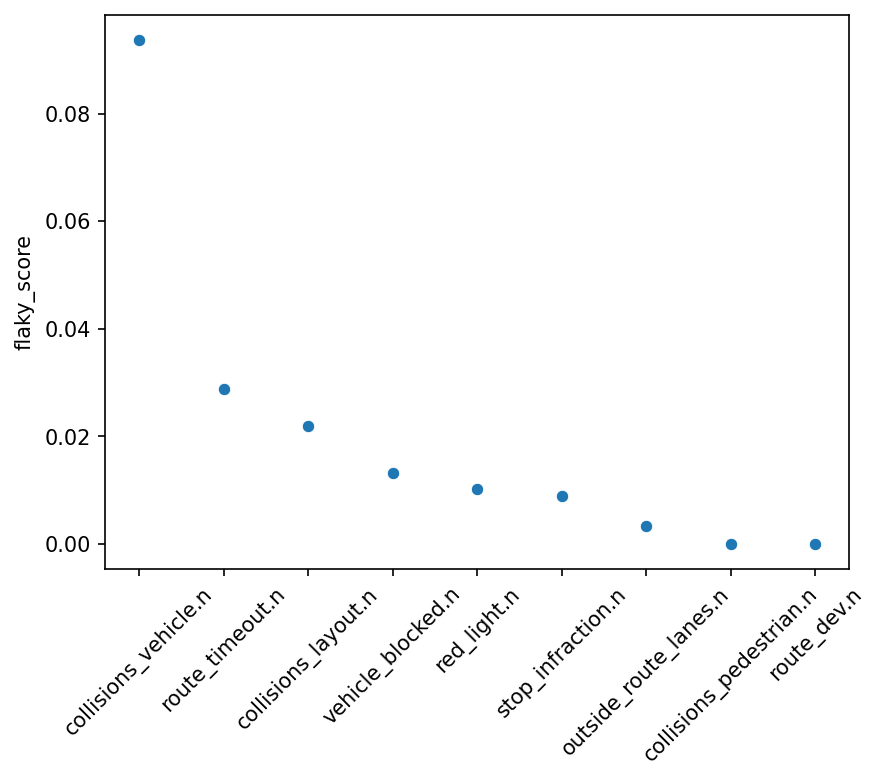

In [63]:
import seaborn as sns
flaky_score = std_of_each_infraction.mean().sort_values(ascending=False)
flaky_score = flaky_score.rename("flaky_score")
my_plot = sns.scatterplot(flaky_score)

my_plot.set_xticklabels(my_plot.get_xticklabels(), rotation=45)
flaky_score

## Impact score


In [60]:
hf_infractions

collisions_layout.n  collisions_pedestrian.n  \
rep route_index                                                 
0   0                              1                        0   
    1                              0                        0   
    2                              0                        0   
    3                              0                        0   
    4                              0                        0   
...                              ...                      ...   
9   127                            0                        0   
    128                            0                        0   
    129                            0                        0   
    130                            0                        0   
    131                            0                        0   

                 collisions_vehicle.n  outside_route_lanes.n  red_light.n  \
rep route_index                                                             
0   0                               0                      0            0   
    1                               0                      0            0   
    2                               0                      0            0   
    3                               0                      0            0   
    4                               0                      0            0   
...                               ...                    ...          ...   
9   127                             0                      0            0   
    128                             0                      0            0   
    129                             0                      0            0   
    130                             1                      0            0   
    131                             0                      0            0   

                 route_dev.n  route_timeout.n  stop_infraction.n  \
rep route_index                                                    
0   0                      0                0                  0   
    1                      0                1                  0   
    2                      0                0                  0   
    3                      0                0                  0   
    4                      0                0                  0   
...                      ...              ...                ...   
9   127                    0                0                  0   
    128                    0                0                  0   
    129                    0                0                  0   
    130                    0                0                  0   
    131                    0                1                  0   

                 vehicle_blocked.n  
rep route_index                     
0   0                            0  
    1                            0  
    2                            0  
    3                            0  
    4                            0  
...                            ...  
9   127                          0  
    128                          0  
    129                          0  
    130                          0  
    131                          0  

[1280 rows x 9 columns]

In [61]:
penalty_factors = {
    "collisions_layout": 0.65,
    "collisions_pedestrian": 0.50,
    "collisions_vehicle": 0.60
}

for col in hf_infractions.columns:
    print(col)
    match col:
        case "collisions_layout.n":
            penalty_factor = 0.5

collisions_layout.n
collisions_pedestrian.n
collisions_vehicle.n
outside_route_lanes.n
red_light.n
route_dev.n
route_timeout.n
stop_infraction.n
vehicle_blocked.n
